### PBCH decoding

PBCH decoding for real-world recorded LTE signal

### Part 1: LTE Signal Spectrum Observation

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, resample_poly, firls

In [12]:
y = scipy.io.loadmat('LTE_803.505MHz_30.72MHz_Short.mat')["samples"][0]
fs = 30.72e6
fs_lte = 7.68e6
THR=15
REPEAT=0

In [13]:
def plot_freq(x, fs):
    N = len(x)
    X = abs (np.fft.fftshift (np.fft.fft(x))) / N
    f = (fs/N * np.arange (-N/2 , N/2 )) / 1e6
    plt.figure()
    plt.plot(f, 20 * np.log10(X))
    plt.xlim(f[1], f[-1])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude [dB]')
    plt.show()

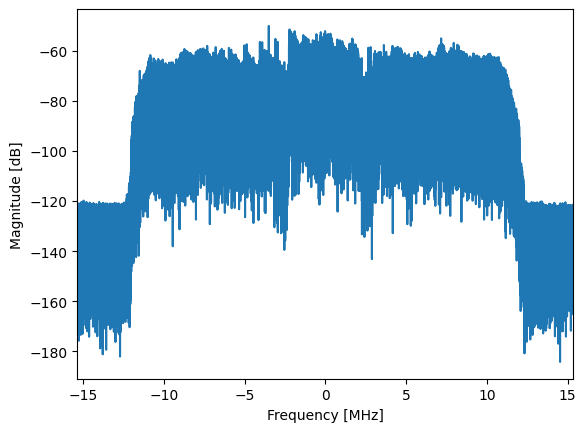

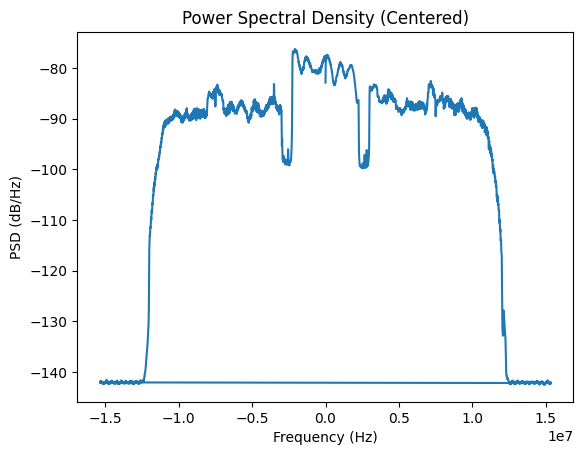

In [14]:
N = len(y)
plot_freq(y, fs)

f, Pxx = welch(
    y,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    nfft=2048,
    return_onesided=False,   # two-sided spectrum
    scaling='density'
)
plt.plot(f, 10*np.log10(Pxx))
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB/Hz)")
plt.title("Power Spectral Density (Centered)")
plt.show()

### Part 2: Integer CFO Correction

Spectrum shift:  80


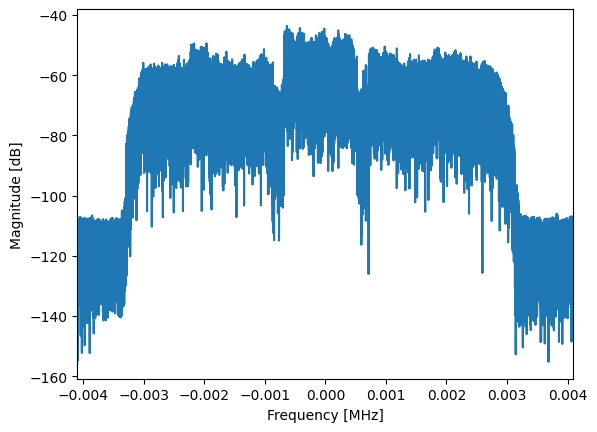

In [15]:
Kmax = 20
Nfft = 2048
Nfftup = int(Nfft * fs / fs_lte)
Ncut = 16* Nfftup
df = fs/Nfftup

s = y[:Ncut]
s = s.reshape(Nfftup, Ncut//Nfftup)
S = np.fft.fftshift(np.fft.fft(s)/Nfftup)
S = np.mean(abs(S), axis=1)

kcentr = Nfftup//2
val = min(S[kcentr-Kmax:kcentr+Kmax])
indx = np.argmin(S[kcentr-Kmax:kcentr+Kmax])
SHIFT = 10*(indx - Kmax)
print("Spectrum shift: ",SHIFT)

y = y * np.exp(-1j * 2 * np.pi * np.arange(N) * (SHIFT*df) / fs)
plot_freq(y[1:Ncut], Nfftup)

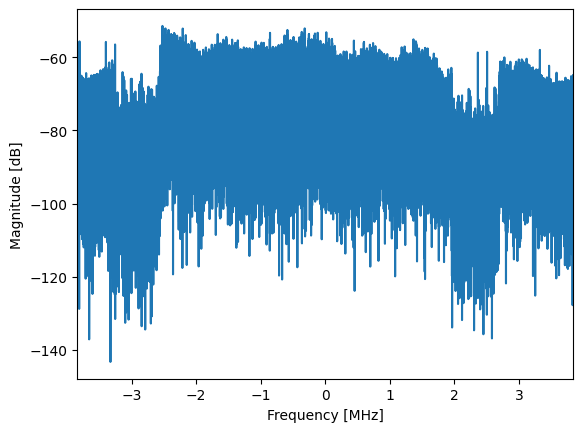

TypeError: firls() missing 1 required positional argument: 'desired'

In [21]:
y = resample_poly(y, up=1, down=int(fs/fs_lte))
fs = fs_lte
N = len(y)
plot_freq(y, fs)
df_lte = 15e3

Mtaps = 125

freq = np.array([0, 72*df_lte, 4*72*df_lte, fs/2]) / (fs/2)
gain = [1,0]
weights = [1, 0.8]
h = firls(Mtaps, freq, gain, weight=weights)
y = np.convolve(y,h,'same')
plot_freq(y, fs)
plt.title("Filtered")